                                                                                                Patricia Grau Francitorra

# Assignment 1: Chinese character "detection"

**Introduction**

Optical character recognition is an old "AI" and image-processing task.  What it involves is taking a photograph or scan of a piece of text (printed or handwritten) and turning the characters (as images) into character codes on the computer that therefore allow the text to be edited, indexed, etc.  A key part of that process is identifying where the characters actually are, especially if the characters are mixed among other non-writing, such as images of objects or people.

In this assignment, you will **take images from a Chinese image database with annotations that indicate where the Chinese characters are, and you will train a model that takes test images, and superimposes upon them a visualization (of your choosing, e.g., a "heat map") of the likelihood that a pixel is close to or part of a valid Chinese character**.  The image database contains annotations of "bounding boxes", coordinates of the corners of a box that contains a single Chinese character.  In a sense, this assignment asks you to detect the bounding boxes in test images without the annotation, but a softer version of this: simply to **provide the probability, for each pixel, whether that pixel was part of a bounding box containing a Chinese character**.  Then, you are to 
   1. **superimpose upon the image a pixel-based map of likelihoods of where the bounding boxes ought to be** and
   2. **apply an evaluation statistic**.

This assignment grants you a lot of freedom in how you organize your code and set up the task overall.  Because of the degree of freedom it involves, it will mostly be graded on our evaluation of the effort put into the solution.  An actual high success at the task is not a requirement to get a high grade.  However, you will have to **report in detail**, in your own format, what you did, why you did it, how to run it -- it must run on mltgpu, be implemented in Python using PyTorch, and make use of the GPUs -- and how to apply it easily to our own test images.

You will have almost a month to do this assignment, even though it is worth only 30% of your grade.  Another assignment with 30% will be given out for the last/remaining two weeks of the study period.   These time periods are coextensive with that of the project, but we expect you to be able to schedule your time well enough to put in an effort at both. This assignment is officially due at 23:59 on 2021 October 18. There are 30 points on this assignment, and a maximum of 20 bonus points.

**The data**

The source of the task is here: https://ctwdataset.github.io/ (Links to an external site.) They have example images and an example of a baseline task that is much more advanced than what we are doing, but it will give you an idea of the data format, particularly the metadata.  Pay attention especially to the "Annotation format" section of this page: https://ctwdataset.github.io/tutorial/1-basics.html (Links to an external site.)

The metadata and a small sample of the whole image dataset is available at /scratch/lt2326-h21/a1 on mltgpu. The metadata is in json format.  info.json contains information about every image file.  We will unzip only a minority of the original training image files.  train.jsonl is a list of json entities, one per line (that have to be parsed with the json package each separately) that correspond to the files in info.json.  This contains the bounding box information, as well as other information for the original challenge on the web.  See the "Annotation format" section mentioned on the dataset web page linked above.

## Part 1: data preparation (7 points)

The image files are in /scratch/lt2326-h21/a1/images on mltgpu. They are in jpg format.  The code that you write for this part of the project should:

- Use the info.json file to figure out what files are in the training set.  You will just use the official training data for everything.  Remember that you will only see a small minority of training examples in the images directory, for space reasons.
- Divide up the official training data files into your own training, validation, and test datasets depending on your own preferences. You can choose to use fewer files than the maximum available if you run into problems with memory and so on (but first make sure your implementation is reasonably efficient).
- Find the corresponding bounding box information in train.jsonl for each image. 

You can represent the data in any way you like, but remember that **it will become a numpy array for processing and a torch tensor for training**.  Remember also that **the classes are defined by pixel: for each pixel, you will eventually have a set of features (e.g. colour values), and a binary class corresponding to whether the pixel was in a Chinese character bounding box or not (note that there are non-Chinese characters in the set -- see the annotation instructions)**.  You are allowed to **reduce the dimensionality of the images for processing, but consider using a pooling and/or upsampling technique in Part 2** of this assignment to accomplish this goal. 

Describe the choices you made and the challenges you found in your report.

In [1]:
import os, sys
from os import listdir
from PIL import Image
import numpy as np
import json
import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mplpath

import random

device = torch.device("cuda:3")

In [2]:
# some info

# Opening JSON file
f = open('/scratch/lt2326-h21/a1/info.json',)

# returns JSON object as a dictionary
info = json.load(f)

# print(info.keys())
# print(info['train'][0])
# print(len(info['train']))

# gets the names of the images in train
im_in_train = []
for a in info['train']:
    name = a['image_id'] + '.jpg'
    im_in_train.append(name)

# Closing file
f.close()

In [3]:
with open('/scratch/lt2326-h21/a1/train.jsonl') as trainfile:
    traindata = [json.loads(x) for x in trainfile]

# let's take a look at the traindata
# traindata[0]

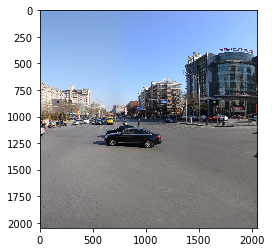

In [5]:
# this is just because I want to see an image

img = mpimg.imread("/scratch/lt2326-h21/a1/images/1000193.jpg")
%matplotlib inline

plt.imshow(img)

In [6]:
# print(im_in_train)
# checking what images are in the images folder

path = '/scratch/lt2326-h21/a1/images'
dirs = os.listdir(path)

usable_img_names = []
for img_name in dirs:
    if img_name in im_in_train:
        usable_img_names.append(img_name)
print('There are', len(usable_img_names), 'images in the image folder that come from the train file.')

# only taking the images that are in the folder

usable_data = []
for e in traindata:
    if e['file_name'] in usable_img_names:
        usable_data.append(e)

# print(usable_data[0])

There are 845 images in the image folder that come from the train file.


In [7]:
# separating data into training, testing and validation data

random.shuffle(usable_data)

usable_train, usable_test, usable_val = np.split(usable_data, [int(len(usable_data)*0.8), int(len(usable_data)*0.9)])

print(len(usable_train), len(usable_test), len(usable_val)) # sanity test

676 84 85


In [8]:
# we have usable_train, a list that contains dictionaries for each image
# {image_id1 : {'chinese' : [[poligon 1], [poligon2]], 'non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
# We will have all the polygons of every image, the ones that contain chinese characters and the ones that don't

def get_chinese(some_usable):
    chinese_im = {}
    
    for image in some_usable:
        chinese_im[image['image_id']] = {'chinese' : [], 'non_chinese' : []}
        for anno in image['annotations']:
            for a in anno:
                if a['is_chinese']:
                    chinese_im[image['image_id']]['chinese'].append(a['polygon'])
                else:
                    chinese_im[image['image_id']]['non_chinese'].append(a['polygon'])
    return chinese_im

In [9]:
chi_train = get_chinese(usable_train)
chi_test = get_chinese(usable_test)
chi_val = get_chinese(usable_val)

train_im_names = list(chi_train.keys())
test_im_names = list(chi_test.keys())
val_im_names = list(chi_val.keys())

In [10]:
chi_train

{'1000927': {'chinese': [[[66.29467726318671, 954.0148749304499],
    [87.71945324936041, 953.6918883577746],
    [85.70412489647788, 979.5935002597689],
    [64.27944460356048, 979.8088236797921]],
   [[97.67926922542574, 953.541740378234],
    [116.91820466504669, 953.2517061756371],
    [114.90285742273136, 979.3000456615264],
    [95.66391997178016, 979.4934018167987]],
   [[126.38218129139477, 953.1090331611776],
    [147.11241735221665, 952.7965170396492],
    [145.09718588376472, 978.9965850739682],
    [124.36685553414281, 979.2049301025982]],
   [[762.9675628225689, 1005.1986802321642],
    [770.2224049413255, 1005.1986802321642],
    [770.2224049413255, 1018.4992241165513],
    [762.9675628225689, 1018.4992241165513]],
   [[770.2224049413255, 1005.1986802321642],
    [777.0742002757067, 1005.1986802321642],
    [777.0742002757067, 1018.4992241165513],
    [770.2224049413255, 1018.4992241165513]],
   [[777.4772470600822, 1005.1986802321642],
    [785.5381827475894, 1005.198680

In [12]:
prova = Image.open('/scratch/lt2326-h21/a1/images/1000193.jpg')
prova_numpy = np.array(prova)
prova_torch = torch.tensor(prova_numpy)
prova_torch.size()

torch.Size([2048, 2048, 3])

In [14]:
img = mpimg.imread("/scratch/lt2326-h21/a1/images/1000193.jpg")
import torchvision.transforms.functional as FT
new_image = FT.to_tensor(img)
new_image.size()

/usr/local/lib64/python3.9/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([3, 2048, 2048])

In [32]:
# getting the gold values for just one image

# making an empty grid
grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
grid.shape = (2048*2048, 2)

# taking all polygons of 1 image
pols = []
for pol in chi_train['1000193']['chinese']:
    pols.append(pol)

# getting the path for each polygon and updating the grid

zeros = np.zeros(2048*2048)
for pol in pols:
    pol_path = mplpath.Path(pol)
    truthvals = pol_path.contains_points(grid)
    # turning it into 0s and 1s    
    truthvals = np.asarray(truthvals, int)
    # updating
    zeros = zeros + truthvals

# this is inefficient af but it works so I need to look for a better solution
bool_arr = np.array(zeros, dtype=bool)
canviem = np.asarray(bool_arr, int)

# checking that there are no pixels with a value different than 1 or 0
# n = 0
# for e in canviem:
#     if e == 1:
#         n+=1
#     elif e >= 1:
#         print('oops', e)
# print(n)

# zeros.shape = (2048, 2048)
canviem.shape = (2048, 2048)

# zeros
canviem

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

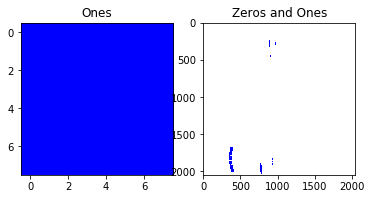

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Random matrix

data_ones = np.random.randint(1, 2, size=(8, 8))
# data_both = np.random.randint(0, 2, size=(8, 8))

# Define colormap

cmapmine = ListedColormap(['w', 'b'], N=2)

# Plot matrix

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_ones, cmap=cmapmine, vmin=0, vmax=1)
ax1.set_title('Ones')
ax2.imshow(canviem, cmap=cmapmine, vmin=0, vmax=1)
ax2.set_title('Zeros and Ones')
plt.show()

In [30]:
def gold_values(chi_data):
    """
    Creates matrices corresponding to images with 1 values where 
    there are polygons containing chinese characters and 0 where 
    there aren't.
    
    Args:
        chi_data: output from get_chinese, a dictionary containing 
        the name of the images and the points where polygons 
        containing chinese and non_chinese characters are. 
        Example: {image_id1 : {'chinese' : [[poligon 1], [poligon2]], '
        non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : 
        {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
        
    Returns:
        a dictionary with the image name and the gold values of the 
        pixels of the image; matrices with 1 values where there is 
        a chinese character (inside the polygons) and 0 where there
        aren't.
        
    """
    d = {}
    
    for image in chi_data:
        
        # taking all polygons of 1 image
        pols = []
        for pol in image['chinese']:
            pols.append(pol)
        
        # making an empty grid
        grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
        grid.shape = (2048*2048, 2)

        # getting the path for each polygon and updating a 0 matrix
        zeros = np.zeros(2048*2048)
        for pol in pols:
            pol_path = mplpath.Path(pol)
            truthvals = pol_path.contains_points(grid)
            # turning it into 0s and 1s    
            truthvals = np.asarray(truthvals, int)
            # updating
            zeros = zeros + truthvals

        # problem! there might be n>1 where polygons overlap
        # this is inefficient but it works so I need to look for a better solution
        bool_arr = np.array(zeros, dtype=bool)
        back_to_int = np.asarray(bool_arr, int)

        back_to_int.shape = (2048, 2048)

        d[image] = back_to_int
    return d

In [11]:
def loadImages(path, train_names, test_names, val_names):
    imagesList = listdir(path)
    
    loadedImages_train = []
    loadedImages_test = []
    loadedImages_val = []
    
    for image in imagesList:
        img = Image.open(path + "/" + image)
        if image[:-4] in train_names:
            loadedImages_train.append(img)
        elif image[:-4] in test_names:
            loadedImages_test.append(img)
        elif image[:-4] in val_names:
            loadedImages_val.append(img)

    return loadedImages_train, loadedImages_test, loadedImages_val

crap = loadImages(path, train_im_names, test_im_names, val_im_names) # OSError: [Errno 24] Too many open files: '/scratch/lt2326-h21/a1/images'

In [117]:
la, le, li = crap
len(la)

676

In [118]:
def fromImagesToTensors(loadedImages, device):
    
    tensors = torch.unsqueeze(torch.tensor(np.array(loadedImages[0])), 0)
    for im in loadedImages[1:]:
        im_numpy = np.array(im)
        im_torch = torch.tensor(im_numpy) # size of [2048, 2048, 3]
        im_torch_1d = torch.unsqueeze(im_torch, 0)
        # im_torch_gpu = im_torch_1d.to(device)
        tensors = torch.cat((tensors, im_torch_1d), 0)
    
    tensors_gpu = tensors.to(device)
    return tensors_gpu

# fromImagesToTensors(crap, device)

crap2 = fromImagesToTensors(la, device)
crap2.size()

torch.Size([676, 2048, 2048, 3])

In [119]:
crap2

tensor([[[[140, 178, 225],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 95, 136, 192],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         [[140, 178, 225],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 96, 137, 193],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         [[139, 177, 224],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 96, 137, 193],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         ...,

         [[127, 124, 119],
          [125, 122, 117],
          [122, 119, 114],
          ...,
          [105, 106, 101],
          [ 92,  93,  88],
          [ 76,  77,  72]],

         [[146, 143, 136],
          [133, 130, 125],
          [122, 119, 114],
          ...,
          [109, 110, 105],
          [104, 105, 100],
          [ 99, 100,  95]],

         [[129, 126, 119],
          [119, 116, 109],
          [109, 106, 101],
         

## Part 2: the models (10 points)

In this part, you will implement two substantially different model archictectures, that both take your representation of the images as training input and both take your representation of the bounding boxes as objective (HINT: the binary classification of pixels as belonging to a bounding box or not).  They will save the trained models to files so that they can be loaded and tested later. The output of the models will be a "soft binary" -- the probability of each pixel being inside a bounding box, from 0 to 1.  Consider examining some of the training data before designing your architectures.

You have a large grant of freedom as to what these model architectures will look like (remember: grading is on a "reasonable effort" basis).  There's a high chance (HINT) that they will both use **one or more convolutional layers**, among other things.  Describe the models and the motivations for the architecture in your report.

In [53]:
# don't forget File > Close and Halt to be good citizens 😇